In [1]:
import torch
from torch_snippets import *
from torchvision.datasets import MNIST
from torchvision import transforms
import numpy as np

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5]),
    transforms.Lambda(lambda x: x.to(device))
])

img_transform2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.to(device))
])

In [5]:
import os
trn_ds = MNIST('data-normalized',transform = img_transform, train=True, download=False)
val_ds = MNIST('data-normalized', transform=img_transform, train=False, download=False)

In [6]:
img, label = trn_ds[0]

In [7]:
img[0][10]

tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -0.8902, -0.9922,  0.2078,  0.9843, -0.2941, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000], device='cuda:0')

In [8]:
batch_size = 256
trn_dl = DataLoader(trn_ds,batch_size=batch_size,shuffle=True)
val_dl = DataLoader(val_ds,batch_size=batch_size, shuffle=False)

In [9]:
class AutoEncoder(nn.Module):
    def __init__(self,latent_dim):
        super(AutoEncoder,self).__init__()
        self.laltent_dim = latent_dim
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64,latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim,64),
            nn.ReLU(),
            nn.Linear(64,128),
            nn.ReLU(),
            nn.Linear(128,28*28),
            nn.Tanh()
        )
    def forward(self,x):
        x = torch.flatten(x,start_dim=2,end_dim=-1)
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.view(len(x), 1, 28, 28)
        return x
    

In [10]:
myAE = AutoEncoder(3).to(device)

In [11]:
total = sum(p.numel() for p in myAE.parameters())/1e6
print(f"There are total of {round(total*1000)},000 parameters")

There are total of 219,000 parameters

In [12]:
def train_batch(input,model,loss_fn,optimizer):
    model.train()
    optimizer.zero_grad()
    output = model(input)
    loss = loss_fn(output,input)
    loss.backward()
    optimizer.step()
    return loss

@torch.no_grad
def validate_batch(input,model,loss_fn):
    model.eval()
    output = model(input)
    loss = loss_fn(output, input)
    return loss

In [13]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.AdamW(myAE.parameters(), lr=0.001, weight_decay=1e-5)

In [14]:
num_epochs = 5
log = Report(num_epochs)

In [15]:
N_trn = len(trn_dl)
N_val = len(val_dl)
for epoch in range(num_epochs):
    for idx, (data, _) in enumerate(trn_dl):
        loss = train_batch(data,myAE,loss_fn,optimizer)
        log.record(pos=(epoch+(idx+1)/N_trn), trn_loss=loss, end="\r")
    for idx, (data, _) in enumerate(val_dl):
        loss = validate_batch(data, myAE, loss_fn)
        log.record(pos=(epoch+(idx+1)/N_val), val_loss = loss, end='\r')
    log.report_avgs(epoch+1)

EPOCH: 1.000  val_loss: 0.195  trn_loss: 0.257  (13.75s - 55.02s remaining)
EPOCH: 2.000  val_loss: 0.170  trn_loss: 0.180  (25.58s - 38.37s remaining)
EPOCH: 3.000  val_loss: 0.159  trn_loss: 0.164  (37.41s - 24.94s remaining)
EPOCH: 4.000  val_loss: 0.155  trn_loss: 0.157  (49.23s - 12.31s remaining)
EPOCH: 5.000  val_loss: 0.150  trn_loss: 0.153  (61.06s - 0.00s remaining)


100%|██████████| 106/106 [00:00<00:00, 5300.13it/s]


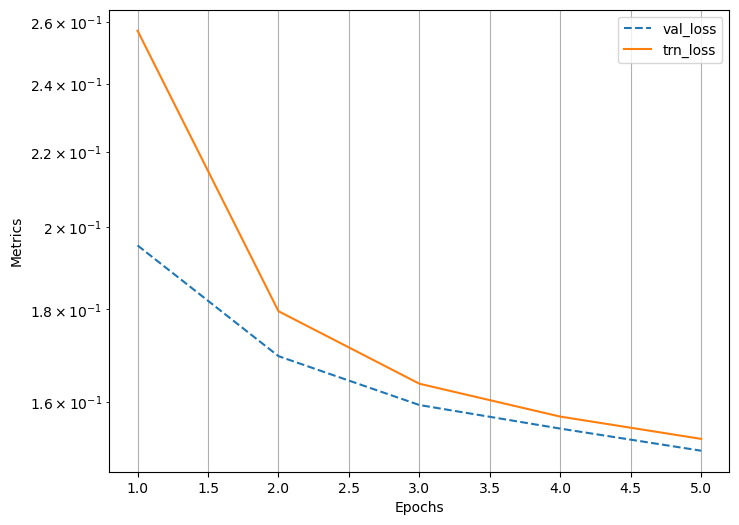

In [16]:
log.plot_epochs(log=True)

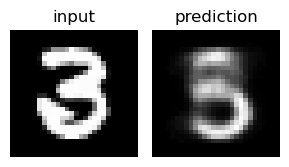

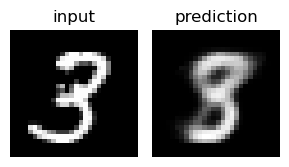

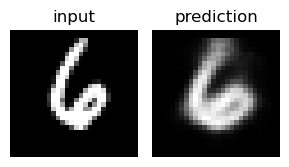

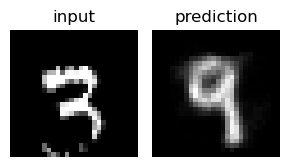

In [18]:
for _ in range(4):
    idx = np.random.randint(len(val_ds))
    im, _ = val_ds[idx]
    im_pred = myAE(im[None])[0] # equivalent to im.unsqueeze(0)
    fig, ax = plt.subplots(1,2, figsize=(3,3))
    show(im[0],ax=ax[0], title="input")
    show(im_pred[0], ax=ax[1], title="prediction")
    plt.tight_layout()
    plt.show()